In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

# pip install scikeras==0.10.0
# pip install tensorflow-model-optimization==0.7.3

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import top_k_accuracy_score

import tensorflow_model_optimization as tfmot

gpus = tf.config.list_physical_devices('GPU')
print("GPU Available: ", gpus)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Ultility

In [3]:
# Ultility function 1: Training Time Monitoring using tensorflow
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [4]:
# Ultility function 2: Measure reasoning time
def measure_reasoning_time(model, X):
    start = time.time()
    model.predict(X)
    end = time.time()
    return end - start

In [52]:
# Ultility function 3: Measure the computational complexity of the model (FLOPs)
from tensorflow.python.framework import convert_to_constants
def get_flops(model):
    # Define the input shape for the model
    input_shape = (1,) + model.input_shape[1:]
    
    # Create a concrete function from the model
    inputs = tf.TensorSpec(shape=input_shape, dtype=tf.float32)
    concrete_function = tf.function(model).get_concrete_function(inputs)
    
    # Convert variables to constants
    frozen_func = convert_to_constants.convert_variables_to_constants_v2(concrete_function)
    graph_def = frozen_func.graph.as_graph_def()
    
    # Import the graph definition
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
        # Run the profiler to calculate FLOPs
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='scope', options=opts)
        
    # Return the total FLOPs
    return flops.total_float_ops if flops is not None else 0

## Data Loading and Preprocessing

In [6]:
# Load the EMNIST data
train_dict = pd.read_pickle('emnist_train.pkl')
test_dict = pd.read_pickle('emnist_test.pkl')

In [7]:
# Convert the data to np arrays
train_images = np.array(train_dict['data'])
train_labels = np.array(train_dict['labels'])
test_images = np.array(test_dict['data'])
test_labels = np.array(test_dict['labels'])

In [8]:
# Add a channel dimension
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

In [9]:
# Resize the images to 32x32
train_images = np.array(tf.image.resize(train_images, [32, 32]))
test_images = np.array(tf.image.resize(test_images, [32, 32]))

In [10]:
# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

In [11]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Test Dataset: <TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## Model: VGG11

### 1. Implement VGG11 Network Structure

In [12]:
def VGG11(input_shape, num_classes=62):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Conv Layer Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [13]:
# Create VGG11 baseline model
vgg11_model = VGG11(input_shape=(32, 32, 1), num_classes=62)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss = keras.losses.SparseCategoricalCrossentropy()
vgg11_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

vgg11_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         5

In [14]:
# Train VGG11 baseline model and measure the training time
vgg11_time_callback = TimeHistory()

history = vgg11_model.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10, callbacks=[vgg11_time_callback])

total_training_time = sum(vgg11_time_callback.times)
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
1563/1563 [==============================] - 22s 11ms/step - loss: 1.4989 - accuracy: 0.6006 - val_loss: 0.6040 - val_accuracy: 0.8036
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6731 - accuracy: 0.7839 - val_loss: 0.4817 - val_accuracy: 0.8345
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5461 - accuracy: 0.8172 - val_loss: 0.4378 - val_accuracy: 0.8467
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4854 - accuracy: 0.8338 - val_loss: 0.4287 - val_accuracy: 0.8497
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4435 - accuracy: 0.8437 - val_loss: 0.4068 - val_accuracy: 0.8547
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4086 - accuracy: 0.8524 - val_loss: 0.4084 - val_accuracy: 0.8576
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3855 - accuracy: 0.8579 - val_loss: 0.4045 -

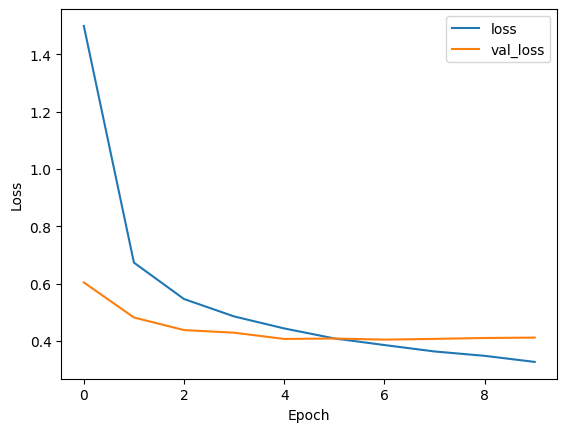

In [15]:
# Plot the loss vs epoch graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 225ms/step


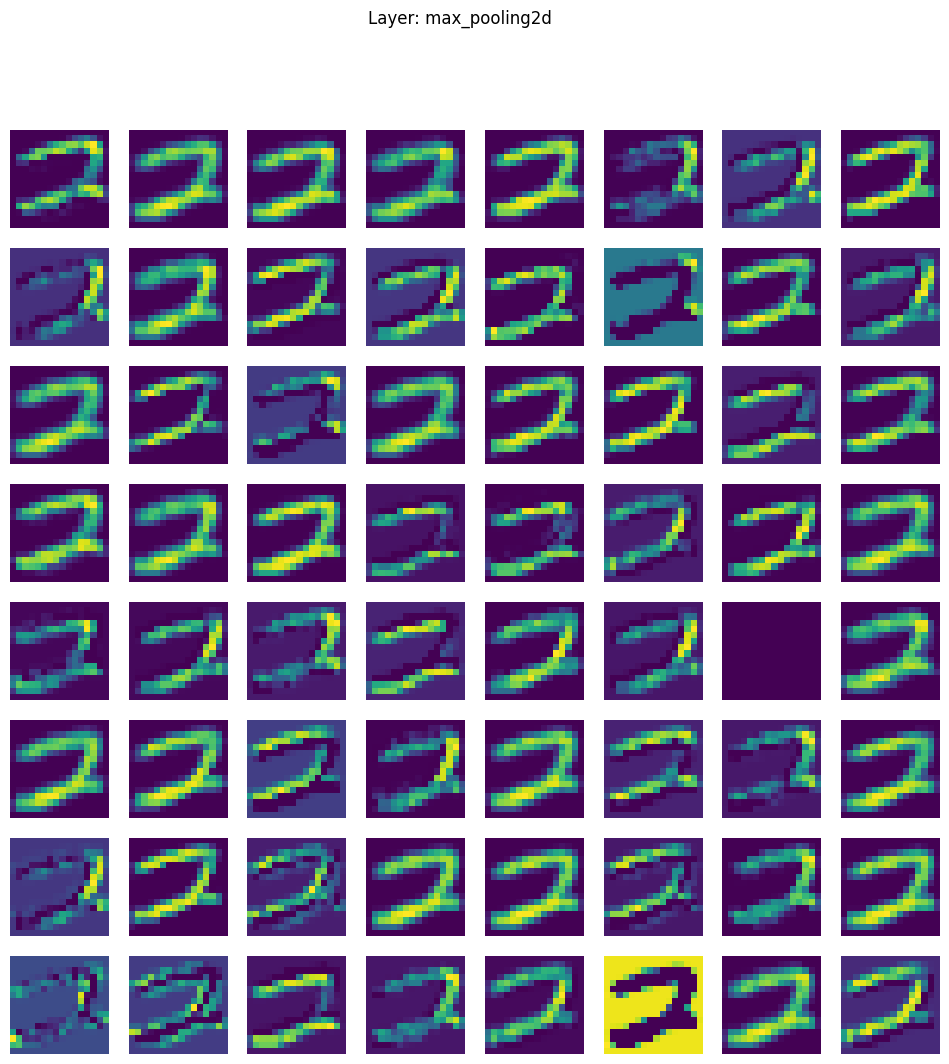

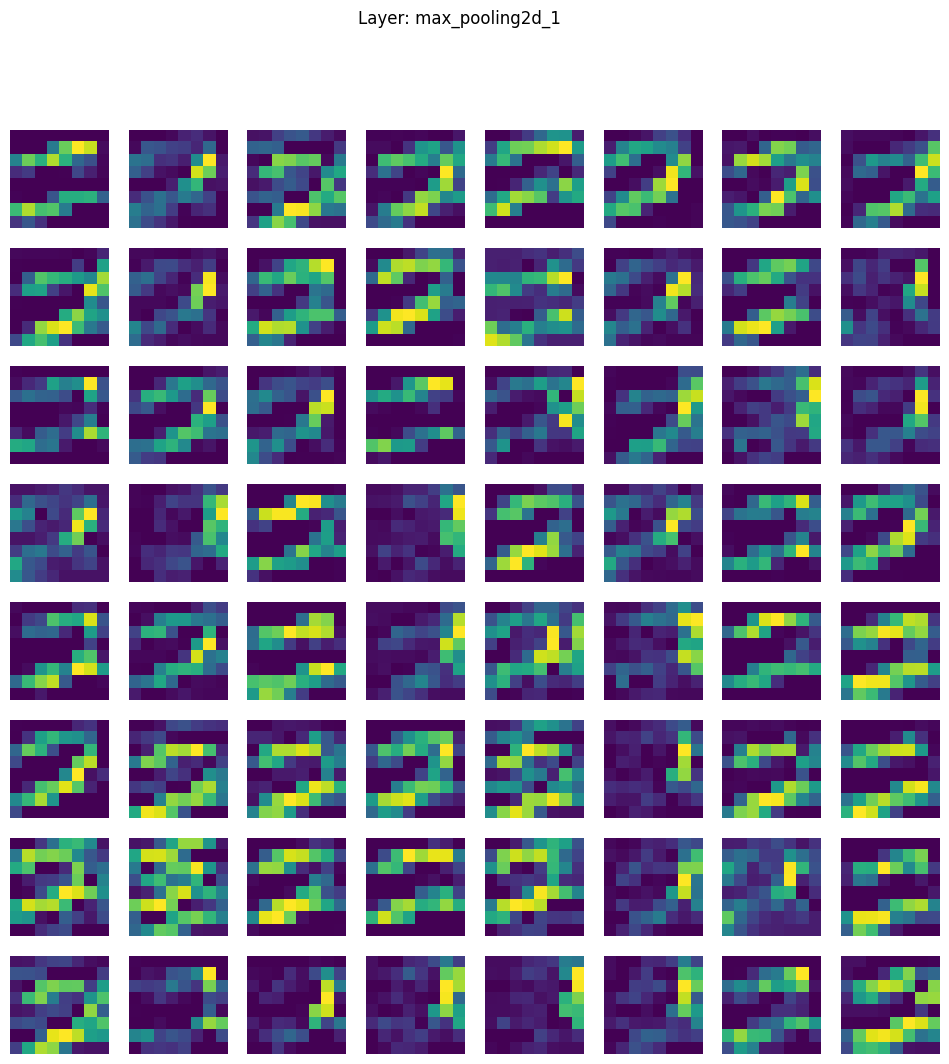

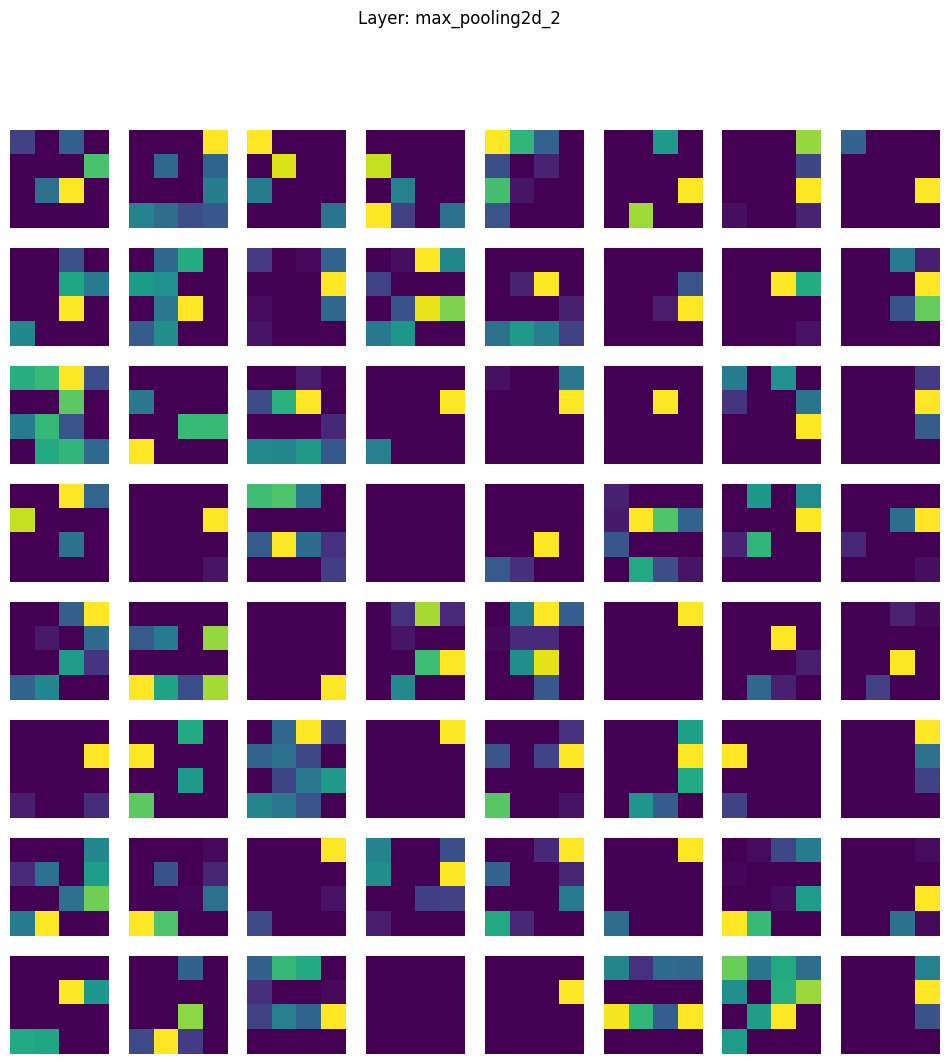

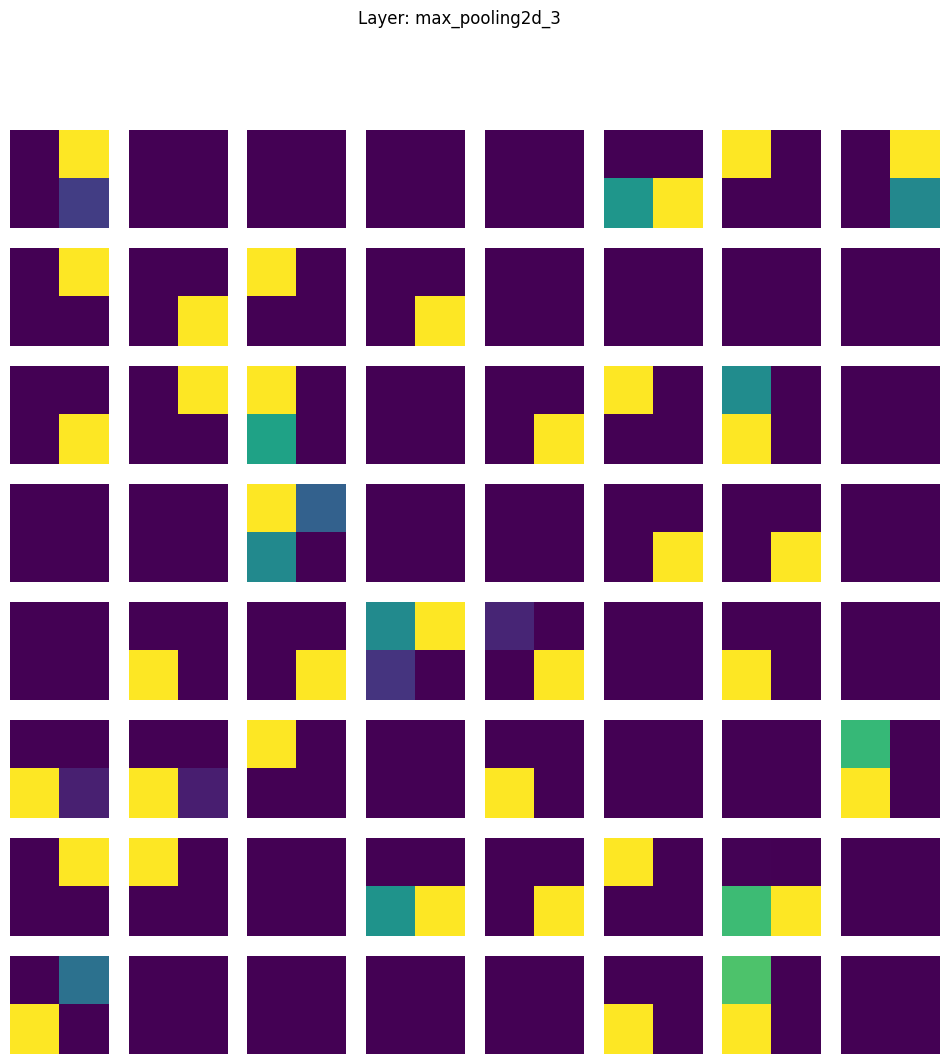

In [16]:
# Visualize hidden layers output
layer_outputs = [layer.output for layer in vgg11_model.layers if 'max_pooling2d' in layer.name]
activation_model = models.Model(inputs=vgg11_model.input, outputs=layer_outputs)
activations = activation_model.predict(test_images[0][np.newaxis, ...])
layer_names = [layer.name for layer in vgg11_model.layers if 'max_pooling2d' in layer.name]
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]      
    plt.figure(figsize=(12,12))
    for i in range(n_features):
        # Display only the first 64 features
        if i >= 64:
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Layer: {layer_name}")
    plt.show()

### 2. Hyperparameter tuning

In [20]:
# Define a function to create the model
def create_model_vgg11(learning_rate, optimizer_name):
    optimizer_dict = {
    'adam': keras.optimizers.Adam,
    'adagrad': keras.optimizers.Adagrad,
    'rmsprop': keras.optimizers.RMSprop
    }
    if optimizer_name in optimizer_dict:
        optimizer = optimizer_dict[optimizer_name](learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    model = VGG11(input_shape=(32, 32, 1), num_classes=62)
    loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [21]:
# Define the hyperparameters
param_grid = {
    'model__learning_rate': [1e-5, 5e-5, 1e-4],
    'model__optimizer_name': ['adam', 'adagrad','rmsprop']
    
    # Debug parameters
    # 'model__learning_rate': [1e-4],
    # 'model__optimizer_name': ['adam']
}

In [22]:
# Wrap the model using KerasClassifier
# Use scikeras.wrappers.KerasClassifier to wrap the model.
keras_model = KerasClassifier(model=create_model_vgg11, epochs=10)

# Perform the grid search
skf = StratifiedKFold(n_splits=3, shuffle=True)
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=skf)
grid_result = grid.fit(train_images, train_labels)

Epoch 1/10
2084/2084 [==============================] - 16s 7ms/step - loss: 1.5640 - accuracy: 0.5840
Epoch 2/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.7033 - accuracy: 0.7765
Epoch 3/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.5643 - accuracy: 0.8116
Epoch 4/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.4951 - accuracy: 0.8311
Epoch 5/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.4506 - accuracy: 0.8415
Epoch 6/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.4180 - accuracy: 0.8512
Epoch 7/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.3879 - accuracy: 0.8593
Epoch 8/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.3650 - accuracy: 0.8648
Epoch 9/10
2084/2084 [==============================] - 14s 7ms/step - loss: 0.3466 - accuracy: 0.8694
Epoch 10/10
1042/1042 [==============================] - 2s 2ms/step
Epoc

In [23]:
# Print the results
# Mean measures the best-performing hyperparameter combination.
# Standard deviation measures the stability of the model's performance.
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Best: 0.858410 using {'model__learning_rate': 0.0001, 'model__optimizer_name': 'adam'}
0.858410 (0.002334) with: {'model__learning_rate': 0.0001, 'model__optimizer_name': 'adam'}


In [26]:
# Train the model with the best hyperparameters
best_lr_vgg11 = grid_result.best_params_['model__learning_rate']
best_opt_vgg11 = grid_result.best_params_['model__optimizer_name']
best_model_vgg11 = create_model_vgg11(best_lr_vgg11, best_opt_vgg11)
history = best_model_vgg11.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.4742 - accuracy: 0.6068 - val_loss: 0.5854 - val_accuracy: 0.8073
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6701 - accuracy: 0.7849 - val_loss: 0.4722 - val_accuracy: 0.8377
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5429 - accuracy: 0.8168 - val_loss: 0.4363 - val_accuracy: 0.8464
Epoch 4/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.4843 - accuracy: 0.8317 - val_loss: 0.4209 - val_accuracy: 0.8515
Epoch 5/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.4447 - accuracy: 0.8424 - val_loss: 0.4108 - val_accuracy: 0.8526
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.4119 - accuracy: 0.8517 - val_loss: 0.4035 - val_accuracy: 0.8569
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.3877 - accuracy: 0.8574 - val_loss: 0.3979 -

In [27]:
y_pred = best_model_vgg11.predict(test_dataset.batch(64))
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels

vgg11_accuracy = accuracy_score(y_true, y_pred)
vgg11_precision = precision_score(y_true, y_pred, average='weighted')
vgg11_recall = recall_score(y_true, y_pred, average='weighted')
vgg11_f1 = f1_score(y_true, y_pred, average='weighted')
vgg11_top5_accuracy = top_k_accuracy_score(y_true, best_model_vgg11.predict(test_dataset.batch(64)), k=5)

print(classification_report(y_true, y_pred))

 37/313 [==>...........................] - ETA: 0s

c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.67      0.79      0.73       976
           1       0.69      0.93      0.79      1023
           2       0.94      0.97      0.96      1003
           3       0.98      1.00      0.99      1035
           4       0.96      0.97      0.96       903
           5       0.95      0.93      0.94       928
           6       0.96      0.98      0.97       959
           7       0.98      0.99      0.99      1098
           8       0.97      0.97      0.97       941
           9       0.93      0.97      0.95       929
          10       0.95      0.96      0.96       170
          11       0.91      0.94      0.93       118
          12       0.77      0.93      0.84       316
          13       0.79      0.92      0.85       128
          14       0.92      0.96      0.94       162
          15       0.88      0.86      0.87       261
          16       0.89   

c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model: ResNet18

### 1. Implement ResNet18 Network Structure
K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.

In [28]:
def residual_block(x, filters, kernel_size=3, downsample=False):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=(2 if downsample else 1), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Add downsample layer
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut connection
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x

def ResNet18(input_shape, num_classes=62):
    inputs = layers.Input(shape=input_shape)

    # Conv Layer Block 1
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual Block 1
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Residual Block 2
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128)

    # Residual Block 3
    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256)

    # Residual Block 4
    # x = residual_block(x, filters=512, downsample=True)
    # x = residual_block(x, filters=512)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    
    return model

In [29]:
# Create ResNet18 baseline model
resnet18_model = ResNet18(input_shape=(32, 32, 1), num_classes=62)

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss = keras.losses.SparseCategoricalCrossentropy()
resnet18_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

resnet18_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 16, 16, 64)   3200        ['input_7[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d_36[0][0]']              
 alization)                                                                                       
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 8, 8, 64)    0           ['batch_normalization[0][0]

In [30]:
# Train the baseline model
resnet18_time_callback = TimeHistory()

history = resnet18_model.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10, callbacks=[resnet18_time_callback])

total_training_time = sum(resnet18_time_callback.times)
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
1563/1563 [==============================] - 20s 12ms/step - loss: 2.9898 - accuracy: 0.3383 - val_loss: 1.5127 - val_accuracy: 0.6267
Epoch 2/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.5505 - accuracy: 0.6117 - val_loss: 1.0166 - val_accuracy: 0.7229
Epoch 3/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.1239 - accuracy: 0.6946 - val_loss: 0.7814 - val_accuracy: 0.7691
Epoch 4/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.8930 - accuracy: 0.7432 - val_loss: 0.6586 - val_accuracy: 0.7969
Epoch 5/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.7555 - accuracy: 0.7743 - val_loss: 0.5943 - val_accuracy: 0.8112
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6623 - accuracy: 0.7962 - val_loss: 0.5552 - val_accuracy: 0.8220
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6003 - accuracy: 0.8114 - val_loss: 0.5288 -

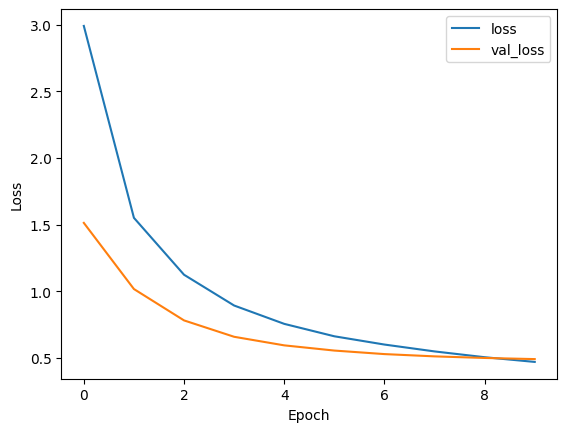

In [31]:
# Plot the loss vs epoch graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Visualize hidden layers output
layer_outputs = [layer.output for layer in resnet18_model.layers if 'conv2d_117' in layer.name or 'conv2d_122' in layer.name or 'conv2d_127' in layer.name]
activation_model = models.Model(inputs=resnet18_model.input, outputs=layer_outputs)
activations = activation_model.predict(test_images[0][np.newaxis, ...])
layer_names = [layer.name for layer in resnet18_model.layers if 'conv2d_117' in layer.name or 'conv2d_122' in layer.name or 'conv2d_127' in layer.name]
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]      
    plt.figure(figsize=(16,16))
    for i in range(n_features):
        # Display only the first 64 features
        if i >= 64:
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Layer: {layer_name}")
    plt.show()

1/1 [==============================] - 0s 43ms/step


### 2. Hyperparameter tuning

In [33]:
# Define a function to create the model
def create_model_resnet18(learning_rate, optimizer_name):
    optimizer_dict = {
    'adam': keras.optimizers.Adam,
    'adagrad': keras.optimizers.Adagrad,
    'rmsprop': keras.optimizers.RMSprop
    }
    if optimizer_name in optimizer_dict:
        optimizer = optimizer_dict[optimizer_name](learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    model = ResNet18(input_shape=(32, 32, 1), num_classes=62)
    loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [34]:
# Define the hyperparameters
param_grid = {
    'model__learning_rate': [5e-5, 1e-4, 5e-4],
    'model__optimizer_name': ['adam', 'adagrad','rmsprop']

    # Debug parameters
    # 'model__learning_rate': [1e-5],
    # 'model__optimizer_name': ['adam']
}

In [35]:
# Wrap the model using KerasClassifier
# Use scikeras.wrappers.KerasClassifier to wrap the model.
keras_model = KerasClassifier(model=create_model_resnet18, epochs=10)

# Perform the grid search
skf = StratifiedKFold(n_splits=3, shuffle=True)
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=skf)
grid_result = grid.fit(train_images, train_labels)

Epoch 1/10
2084/2084 [==============================] - 36s 16ms/step - loss: 3.0483 - accuracy: 0.3284
Epoch 2/10
2084/2084 [==============================] - 33s 16ms/step - loss: 1.5936 - accuracy: 0.6003
Epoch 3/10
2084/2084 [==============================] - 29s 14ms/step - loss: 1.1508 - accuracy: 0.6886
Epoch 4/10
2084/2084 [==============================] - 31s 15ms/step - loss: 0.9213 - accuracy: 0.7374
Epoch 5/10
2084/2084 [==============================] - 31s 15ms/step - loss: 0.7871 - accuracy: 0.7675
Epoch 6/10
2084/2084 [==============================] - 30s 14ms/step - loss: 0.6912 - accuracy: 0.7905
Epoch 7/10
2084/2084 [==============================] - 30s 15ms/step - loss: 0.6286 - accuracy: 0.8035
Epoch 8/10
2084/2084 [==============================] - 30s 14ms/step - loss: 0.5737 - accuracy: 0.8172
Epoch 9/10
2084/2084 [==============================] - 29s 14ms/step - loss: 0.5351 - accuracy: 0.8268
Epoch 10/10
1042/1042 [==============================] - 5s 5ms/

In [36]:
# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Best: 0.833230 using {'model__learning_rate': 1e-05, 'model__optimizer_name': 'adam'}
0.833230 (0.001792) with: {'model__learning_rate': 1e-05, 'model__optimizer_name': 'adam'}


In [37]:
# Train the model with the best hyperparameters
best_lr_resnet18 = grid_result.best_params_['model__learning_rate']
best_opt_resnet18 = grid_result.best_params_['model__optimizer_name']
best_model_resnet18 = create_model_resnet18(best_lr_resnet18, best_opt_resnet18)
history = best_model_resnet18.fit(train_dataset.batch(64), validation_data=test_dataset.batch(64), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 23s 14ms/step - loss: 2.9951 - accuracy: 0.3394 - val_loss: 1.5453 - val_accuracy: 0.6177
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5695 - accuracy: 0.6054 - val_loss: 1.0226 - val_accuracy: 0.7157
Epoch 3/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.1294 - accuracy: 0.6907 - val_loss: 0.7805 - val_accuracy: 0.7697
Epoch 4/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.8975 - accuracy: 0.7407 - val_loss: 0.6623 - val_accuracy: 0.7967
Epoch 5/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.7572 - accuracy: 0.7724 - val_loss: 0.5965 - val_accuracy: 0.8108
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.6699 - accuracy: 0.7941 - val_loss: 0.5569 - val_accuracy: 0.8200
Epoch 7/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.6027 - accuracy: 0.8101 - val_loss: 0.5307 -

In [38]:
y_pred = best_model_resnet18.predict(test_dataset.batch(64))
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels

resnet18_accuracy = accuracy_score(y_true, y_pred)
resnet18_precision = precision_score(y_true, y_pred, average='weighted')
resnet18_recall = recall_score(y_true, y_pred, average='weighted')
resnet18_f1 = f1_score(y_true, y_pred, average='weighted')
resnet18_top5_accuracy = top_k_accuracy_score(y_true, best_model_resnet18.predict(test_dataset.batch(64)), k=5)

print(classification_report(y_true, y_pred))

 27/313 [=>............................] - ETA: 1s

c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.67      0.74      0.71       976
           1       0.67      0.89      0.77      1023
           2       0.92      0.96      0.94      1003
           3       0.97      0.98      0.98      1035
           4       0.93      0.97      0.95       903
           5       0.90      0.89      0.90       928
           6       0.94      0.97      0.95       959
           7       0.97      0.99      0.98      1098
           8       0.94      0.97      0.95       941
           9       0.92      0.97      0.94       929
          10       0.92      0.91      0.91       170
          11       0.83      0.77      0.80       118
          12       0.75      0.85      0.80       316
          13       0.83      0.80      0.82       128
          14       0.95      0.86      0.90       162
          15       0.81      0.88      0.84       261
          16       0.90   

c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\IcyPo\.conda\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluation

In [53]:
models = {
    'VGG11': best_model_vgg11,
    'ResNet18': best_model_resnet18,
    # 'EfficientNetB0': best_model_efficientnetb0,
}
acc = {
    'VGG11': vgg11_accuracy,
    'ResNet18': resnet18_accuracy,
    # 'EfficientNetB0': efficientnetb0_accuracy,
}
training_time = {
    'VGG11': sum(vgg11_time_callback.times),
    'ResNet18': sum(resnet18_time_callback.times),
    # 'EfficientNetB0': sum(efficientnetb0_time_callback.times),
}
reasoning_time = {
    'VGG11': measure_reasoning_time(best_model_vgg11, test_images),
    'ResNet18': measure_reasoning_time(best_model_resnet18, test_images),
    # 'EfficientNetB0': measure_reasoning_time(best_model_efficientnetb0, test_images),
}
flops = {
    'VGG11': get_flops(best_model_vgg11),
    'ResNet18': get_flops(best_model_resnet18),
    # 'EfficientNetB0': get_flops(best_model_efficientnetb0),
}
for name, model in models.items():
    print(f"Model: {name}")
    print(f"Accuracy: {acc[name]:.4f}")
    print(f"Training Time: {training_time[name]:.2f} seconds")
    print(f"Reasoning Time: {reasoning_time[name]:.4f} seconds")
    print(f"FLOPs: {flops[name]:.2f}")
    print("\n"+"\n")

625/625 [==============================] - 2s 4ms/step
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Model: VGG11
Accuracy: 0.8610
Training Time: 165.18 seconds
Reasoning Time: 1.8044 seconds
FLOPs: 268377460.00



Model: ResNet18
Accuracy: 0.8364
Training Time: 203.78 seconds
Reasoning Time: 2.4628 seconds
FLOPs: 54152564.00





## Comparison

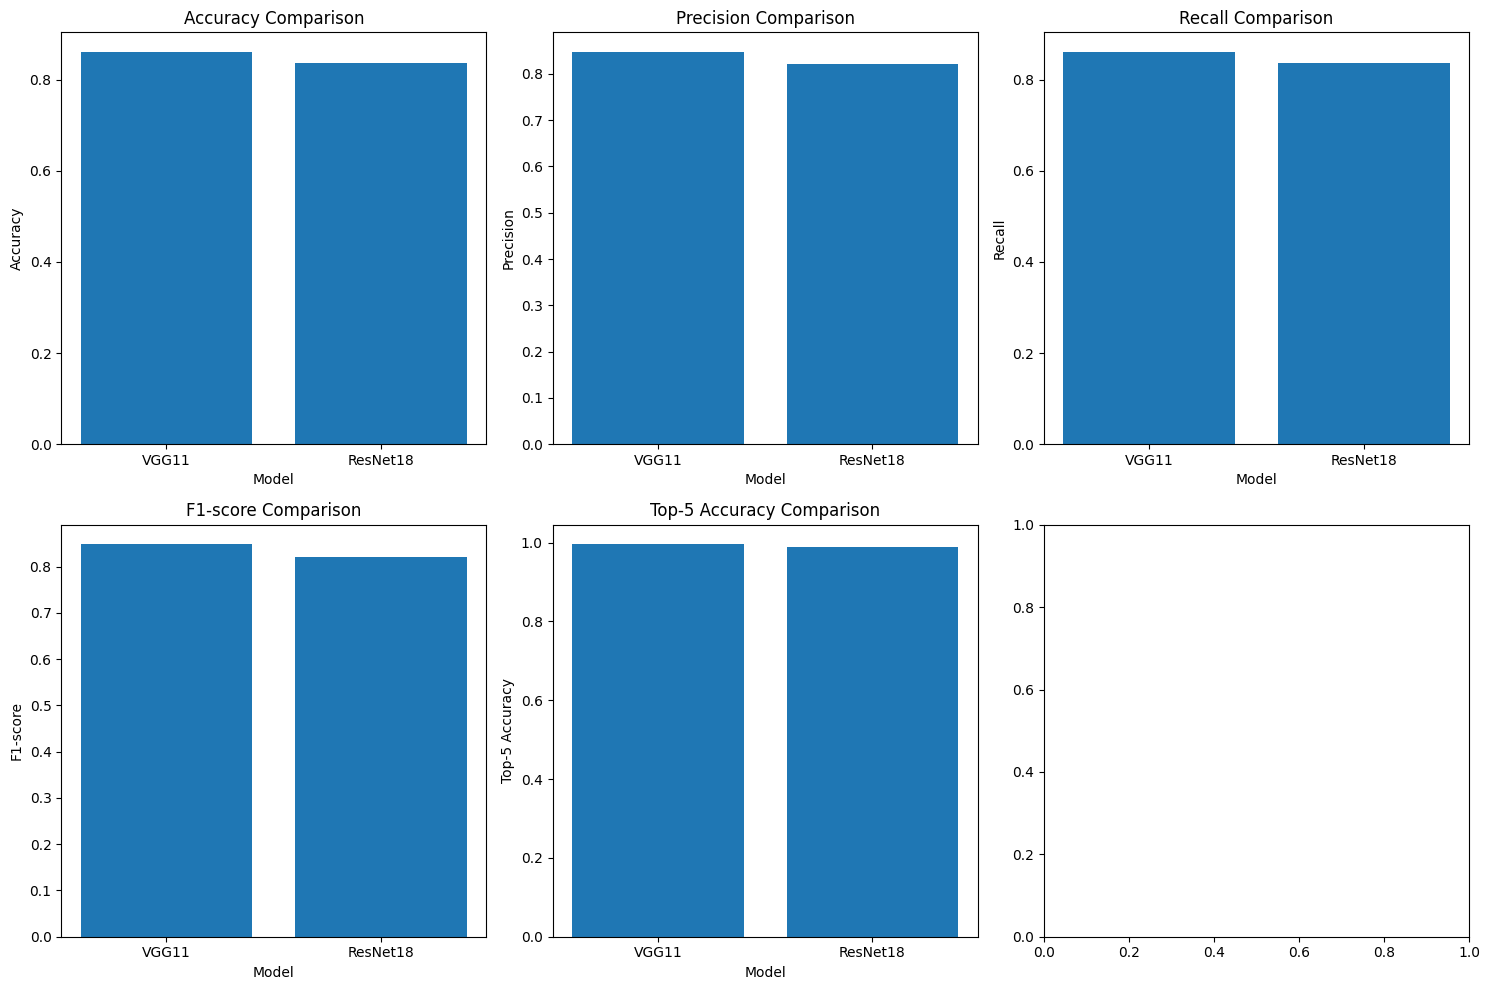

In [54]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Top-5 Accuracy']
vgg11_metrics = [vgg11_accuracy, vgg11_precision, vgg11_recall, vgg11_f1, vgg11_top5_accuracy]
resnet18_metrics = [resnet18_accuracy, resnet18_precision, resnet18_recall, resnet18_f1, resnet18_top5_accuracy]
# efficientnetb0_metrics = [efficientnetb0_accuracy, efficientnetb0_precision, efficientnetb0_recall, efficientnetb0_f1, efficientnetb0_top5_accuracy]

# Plot the performance metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    ax.bar(['VGG11', 'ResNet18'], [vgg11_metrics[i], resnet18_metrics[i]])
    # ax.bar(['VGG11', 'ResNet18', 'EfficientNetB0'], [vgg11_metrics[i], resnet18_metrics[i], efficientnetb0_metrics[i]])
    ax.set_title(metric + ' Comparison')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
plt.tight_layout()
plt.show()

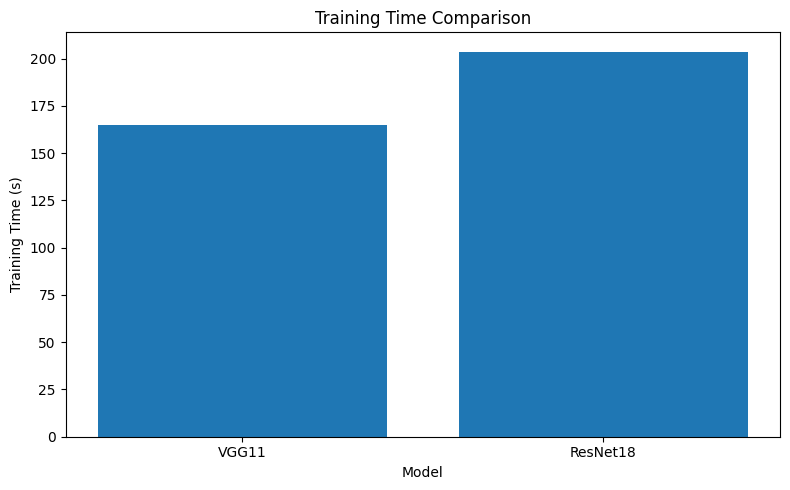

In [55]:
# Plot the training time metric
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['VGG11', 'ResNet18'], [training_time['VGG11'], training_time['ResNet18']])
# ax.bar(['VGG11', 'ResNet18', 'EfficientNetB0'], [training_time['VGG11'], training_time['ResNet18'], training_time['EfficientNetB0']])
ax.set_title('Training Time Comparison')
ax.set_ylabel('Training Time (s)')
ax.set_xlabel('Model')
plt.tight_layout()
plt.show()

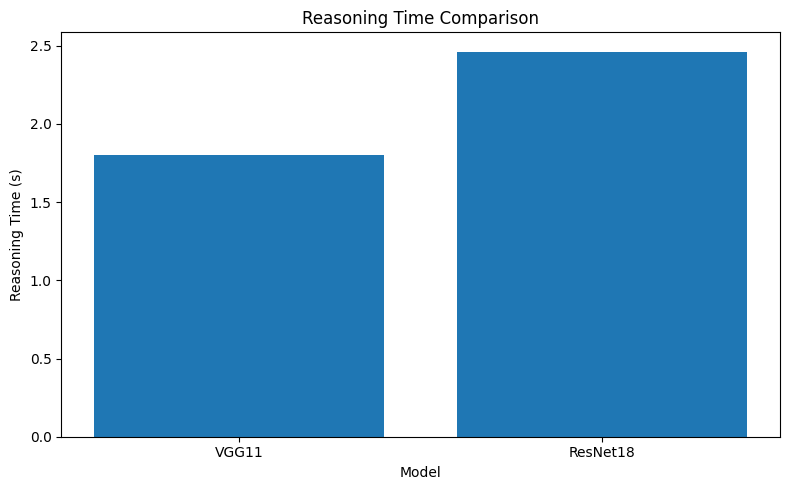

In [56]:
# Plot the reasoning time metric
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['VGG11', 'ResNet18'], [reasoning_time['VGG11'], reasoning_time['ResNet18']])
# ax.bar(['VGG11', 'ResNet18', 'EfficientNetB0'], [reasoning_time['VGG11'], reasoning_time['ResNet18'], reasoning_time['EfficientNetB0']])
ax.set_title('Reasoning Time Comparison')
ax.set_ylabel('Reasoning Time (s)')
ax.set_xlabel('Model')
plt.tight_layout()
plt.show()

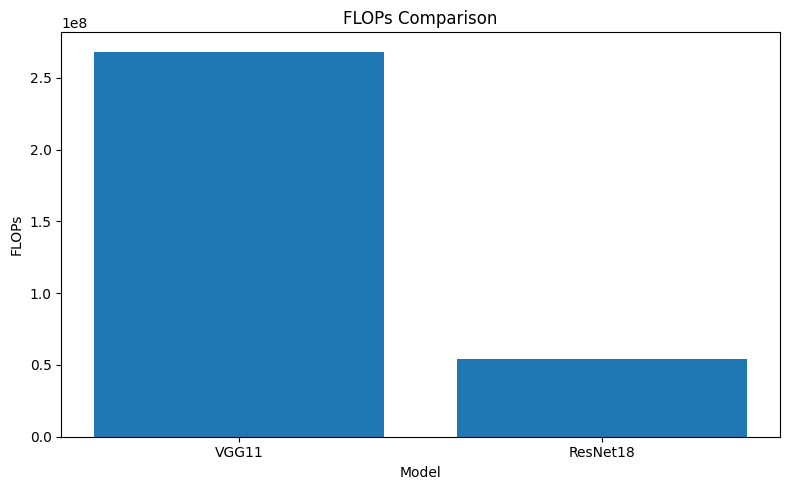

In [57]:
# Plot the FLOPs metric
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['VGG11', 'ResNet18'], [flops['VGG11'], flops['ResNet18']])
# ax.bar(['VGG11', 'ResNet18', 'EfficientNetB0'], [flops['VGG11'], flops['ResNet18'], flops['EfficientNetB0']])
ax.set_title('FLOPs Comparison')
ax.set_ylabel('FLOPs')
ax.set_xlabel('Model')
plt.tight_layout()
plt.show()